In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist as pdist
from scipy.spatial.distance import squareform as squareform

In [30]:
def Build_Patterns(N_Patt=10,N_Repl=100,Noise_Level=0.1,N_CA3=100):
    Templ = np.random.rand(N_Patt,N_CA3)
    
    Patt = np.zeros((N_Patt*N_Repl,N_CA3))
    kk = 0
    for tt in range(N_Patt):
        for cc in range(N_Repl):
            Patt[kk,:] = Templ[tt,:]+np.random.normal(loc=0,scale=Noise_Level,size=Templ[tt,:].shape)   
            kk += 1
    Patt[Patt<0] = 0
    
    for zz in range(Patt.shape[0]):
        Patt[zz,:] = Normalize_Activity(Patt[zz,:],m_trgt=1,s_trgt=0.3)
    
    
    return Patt
    

def Connections_Init(N_CA3,N_CA1):
    Conn = np.random.rand(N_CA3,N_CA1)
    Conn = Conn/np.linalg.norm(Conn,axis=0,ord=1)
    return Conn

def Compute_Sparsity(Vec):
    sp = (np.mean(Vec))**2/np.mean(Vec**2)
    return sp


def Normalize_Activity(Act,m_trgt=1,s_trgt=0.1):
    s = 1
    thr = np.mean(Act)
    thr_u = np.max(Act)
    thr_d = np.min(Act)
    cc = 0
    while np.abs(s-s_trgt)>0.01:
        Act_thr = Act - thr
        Act_thr[Act_thr<0] = 0

        s = Compute_Sparsity(Act_thr)
        dec_s = np.sign(s-s_trgt)
        if dec_s==1:
            thr_d,thr,thr_u = [thr, (thr_u+thr_d)/2, thr_u]
        else:
            thr_d,thr,thr_u = [thr_d, (thr_u+thr_d)/2, thr]
        cc = cc + 1
        if(cc>1000):
            break
            
    Act_thr = Act_thr/np.mean(Act_thr)*m_trgt
    return Act_thr

def Compute_Plasticity(Pre,Post,eta=0.001):
    dw = Pre @ ((Post-np.mean(Post,axis=0)).T)
    dw = dw * eta
    return dw

def Apply_Plasticity(Conn,dw_tot):
    Conn += dw_tot
    Conn[Conn<0] = 0
    Conn = Conn/np.linalg.norm(Conn,axis=0,ord=1)
    Conn[np.isnan(Conn)] = 0
    return Conn


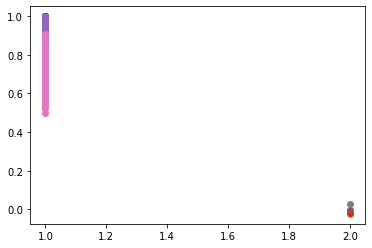

In [36]:
eta_l = 0.00001
n_rounds = 10
N_CA3 = 100

Patt = Build_Patterns(N_Patt=20,N_Repl=100,Noise_Level=0.1,N_CA3=N_CA3)


for spars in [0.1,0.2,0.3]:
    
    N_CA1 = N_CA3 * 3
    Conn = Connections_Init(N_CA3,N_CA1)
    # TRAINING
    for l_round in range(n_rounds):
        dw_tot = 0
        for zz in range(Patt.shape[0]):
            Act_Obj = Patt[zz,:]
            CA1_Act = Act_Obj@Conn


            CA1_Time = Normalize_Activity(CA1_Act,1,s_trgt=spars)

            Pre = Act_Obj[:,np.newaxis]

            Post = CA1_Time[:,np.newaxis]

            dw_tot += Compute_Plasticity(Pre,Post,eta=eta_l)

        Conn = Apply_Plasticity(Conn,dw_tot)


    # TESTING
    CA1_Out = np.zeros((Patt.shape[0],N_CA1)) 
    for zz in range(Patt.shape[0]):
        Act_Obj = Patt[zz,:]
        CA1_Act = Act_Obj@Conn


        CA1_Out[zz,:] = Normalize_Activity(CA1_Act,1,s_trgt=spars)


    CA1_DD = squareform(1 - pdist(CA1_Out,metric='correlation'))
    in_comp = squareform(CA1_DD[0:100,0:100])  
    plt.scatter(np.ones(in_comp.shape)*1,in_comp)
    out_comp = CA1_DD[0:100,100:].flatten()
    #plt.scatter(np.ones(out_comp.shape)*2,out_comp)
    plt.scatter(2,np.mean(out_comp)) 

CA3_Out = np.zeros((Patt.shape[0],N_CA3)) 
for zz in range(Patt.shape[0]):
    CA3_Out[zz,:] = Patt[zz,:]
CA3_DD = squareform(1 - pdist(CA3_Out,metric='correlation'))
in_comp = squareform(CA3_DD[0:100,0:100])  
plt.scatter(np.ones(in_comp.shape)*1,in_comp)
out_comp = CA3_DD[0:100,100:].flatten()
#plt.scatter(np.ones(out_comp.shape)*2,out_comp)
plt.scatter(2,np.mean(out_comp)) 

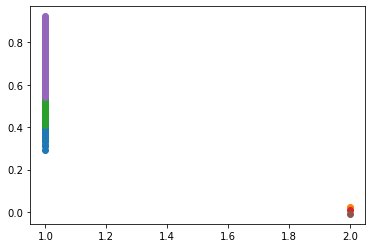

In [33]:
eta_l = 0.0001
n_rounds = 0 # NO LEARNING
N_CA3 = 100

Patt = Build_Patterns(N_Patt=10,N_Repl=100,Noise_Level=0.1,N_CA3=N_CA3)


for spars in [0.1,0.2,0.3]:
    
    N_CA1 = N_CA3 * 3
    Conn = Connections_Init(N_CA3,N_CA1)
    # TRAINING
    for l_round in range(n_rounds):
        dw_tot = 0
        for zz in range(Patt.shape[0]):
            Act_Obj = Patt[zz,:]
            CA1_Act = Act_Obj@Conn


            CA1_Time = Normalize_Activity(CA1_Act,1,s_trgt=spars)

            Pre = Act_Obj[:,np.newaxis]

            Post = CA1_Time[:,np.newaxis]

            dw_tot += Compute_Plasticity(Pre,Post,eta=eta_l)

        Conn = Apply_Plasticity(Conn,dw_tot)


    # TESTING
    CA1_Out = np.zeros((Patt.shape[0],N_CA1)) 
    for zz in range(Patt.shape[0]):
        Act_Obj = Patt[zz,:]
        CA1_Act = Act_Obj@Conn


        CA1_Out[zz,:] = Normalize_Activity(CA1_Act,1,s_trgt=spars)


    CA1_DD = squareform(1 - pdist(CA1_Out,metric='correlation'))
    in_comp = squareform(CA1_DD[0:100,0:100])  
    plt.scatter(np.ones(in_comp.shape)*1,in_comp)
    out_comp = CA1_DD[0:100,100:].flatten()
    #plt.scatter(np.ones(out_comp.shape)*2,out_comp)
    plt.scatter(2,np.mean(out_comp)) 

# CA3_Out = np.zeros((XY_Coor.shape[0],N_CA3)) 
# for zz in range(XY_Coor.shape[0]):
#     CA3_Out[zz,:] = PlaceField(XY_Coor[zz][0],XY_Coor[zz][1],X_Pf.flatten(),Y_Pf.flatten())
# CA3_DD = 1 - pdist(CA3_Out,metric='correlation')
# plt.scatter(XY_DD,CA3_DD)